<a href="https://colab.research.google.com/github/liangwuweb/Intrusion_detection_ML/blob/main/intrusion_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import csv

# Machine learning Model
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

# Machine learning model evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix

# **Fetch data**

In [47]:
df = datasets.fetch_openml(data_id=1113)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [48]:
print(df.feature_names)
df.data
print(df.target.unique())
for name in df.target.unique():
  print(name)
type(df.data)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell', 'lsu_attempted', 'lnum_root', 'lnum_file_creations', 'lnum_shells', 'lnum_access_files', 'lnum_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
['normal', 'buffer_overflow', 'loadmodule', 'perl', 'neptune', ..., 'multihop', 'warezmaster', 'warezclient', 'spy', 'rootkit']
Length: 23
Categories (23, object): ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', ..., 'spy',
                          'tea

pandas.core.frame.DataFrame

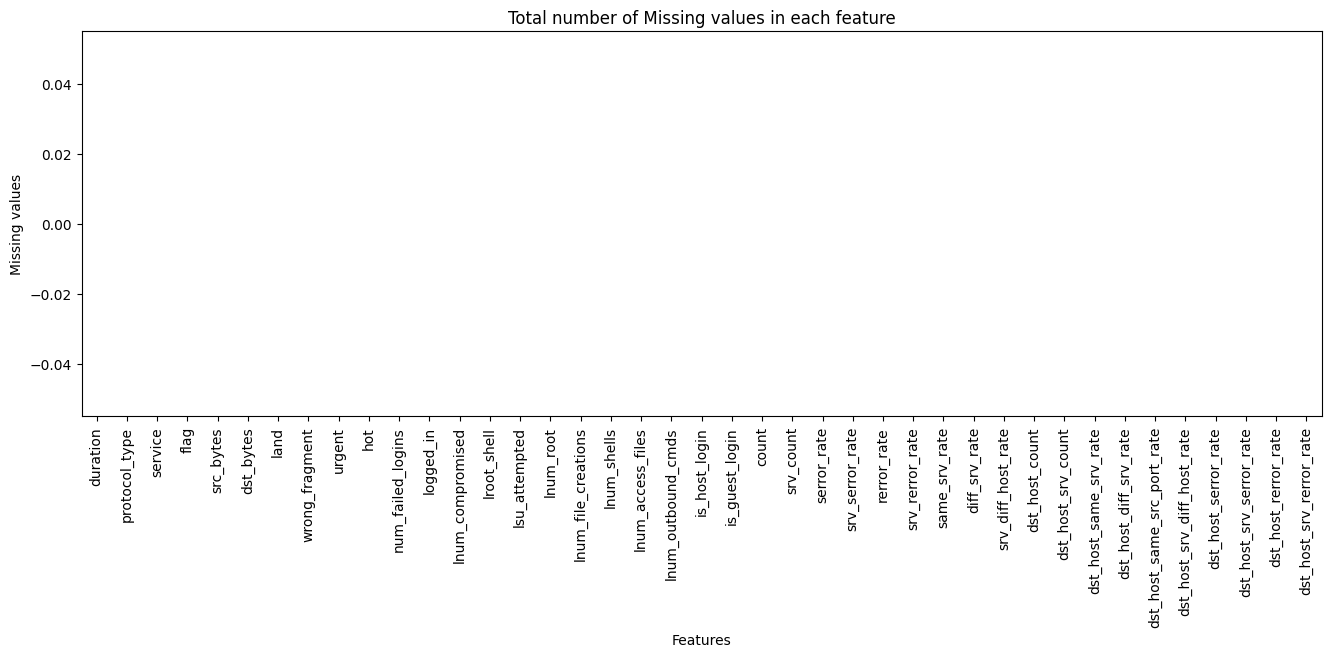

In [49]:

def plotMissingValues(dataframe):
    missing_values = dataframe.isnull().sum()  # Counting null values for each column
    fig = plt.figure(figsize=(16, 5))
    missing_values.plot(kind='bar', color='deepskyblue')
    plt.xlabel("Features")
    plt.ylabel("Missing values")
    plt.title("Total number of Missing values in each feature")
    plt.show()

plotMissingValues(df.data)

# **Data Virtualization**

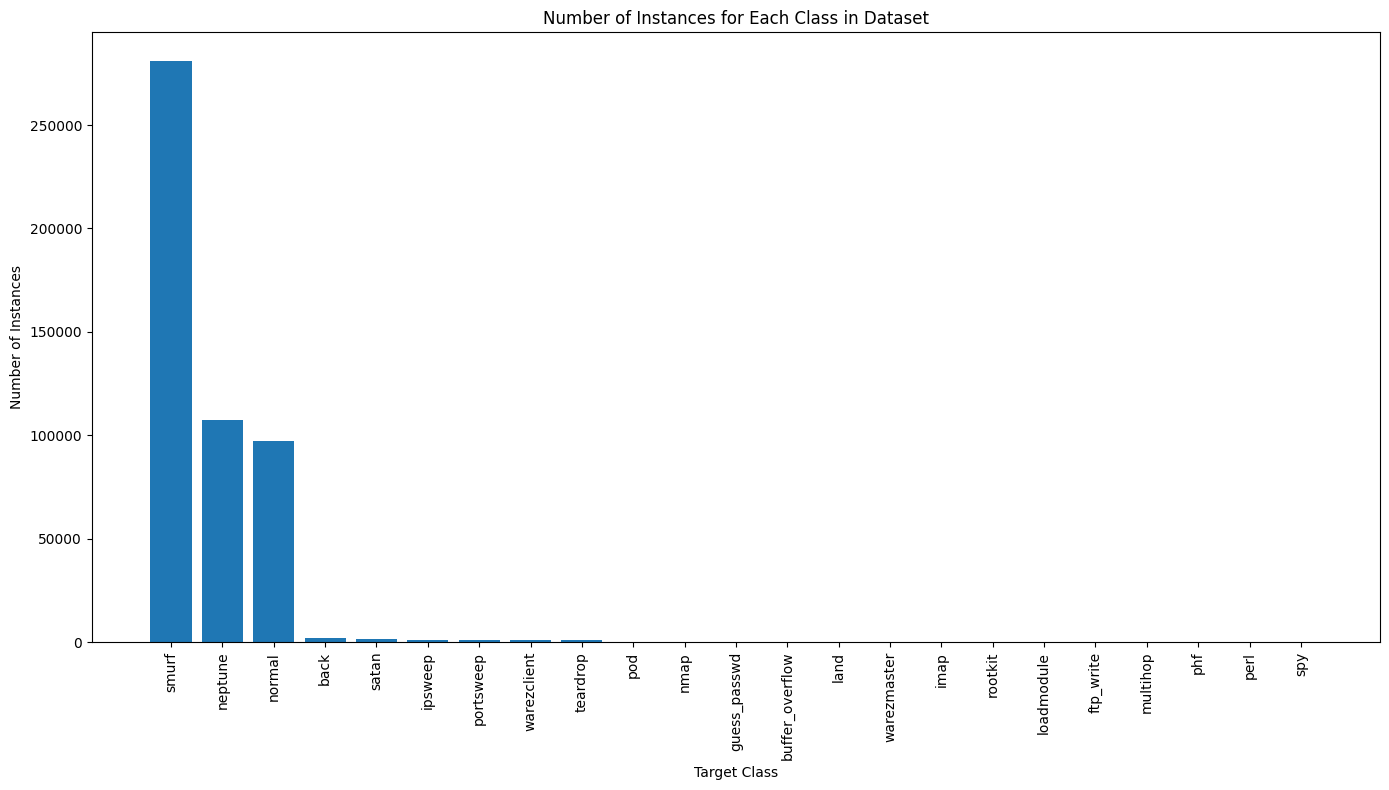

In [50]:
# Count the number of instances for each class
class_counts = df['target'].value_counts()

# Set up the matplotlib figure and size
plt.figure(figsize=(14, 8))

# Create a bar chart
plt.bar(class_counts.index, class_counts.values)

# Improve Aesthetics of Plot
plt.xticks(rotation=90)  # Rotate class names for better readability
plt.xlabel('Target Class')
plt.ylabel('Number of Instances')
plt.title('Number of Instances for Each Class in Dataset')
plt.tight_layout()  # Adjust layout to fit all class names

# Show the plot
plt.show()

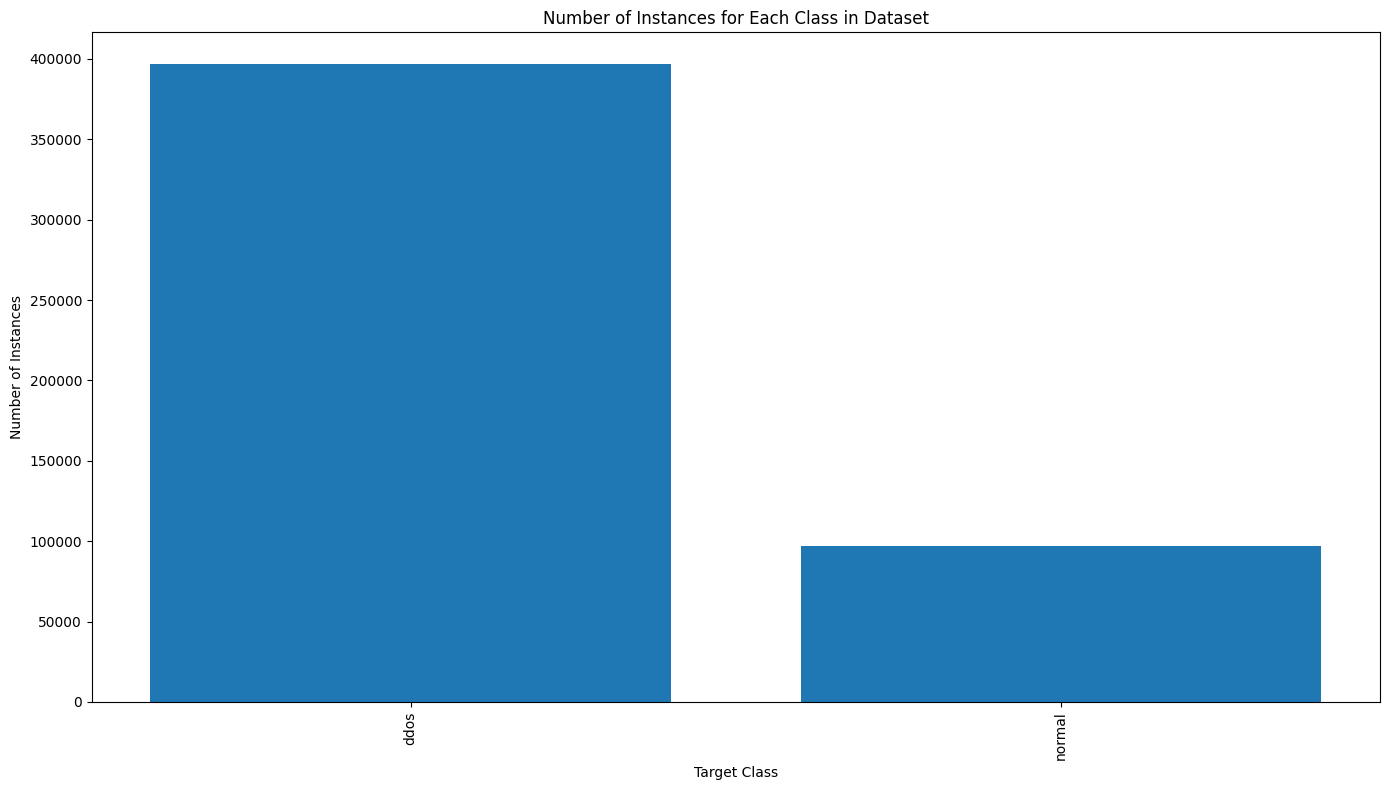

0         0
1         0
2         0
3         0
4         0
         ..
494015    0
494016    0
494017    0
494018    0
494019    0
Name: label, Length: 494020, dtype: int64

In [51]:
# Convert all non-'normal' classes to 'ddos'
df['target'] = df['target'].apply(lambda x: 'ddos' if x != 'normal' else 'normal')
# Count the number of instances for each class
class_counts = df['target'].value_counts()

# Set up the matplotlib figure and size
plt.figure(figsize=(14, 8))

# Create a bar chart
plt.bar(class_counts.index, class_counts.values)

# Improve Aesthetics of Plot
plt.xticks(rotation=90)  # Rotate class names for better readability
plt.xlabel('Target Class')
plt.ylabel('Number of Instances')
plt.title('Number of Instances for Each Class in Dataset')
plt.tight_layout()  # Adjust layout to fit all class names

# Show the plot
plt.show()

# Convert the labels in the DataFrame to numerical values
df['target'] = df['target'].map({'normal': 0, 'ddos': 1})

#describe the dataset
df['target']

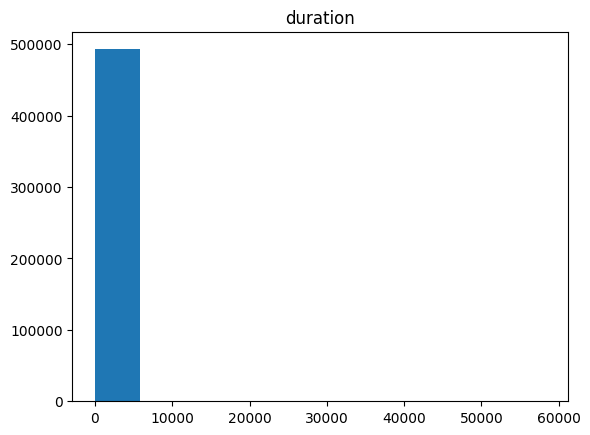

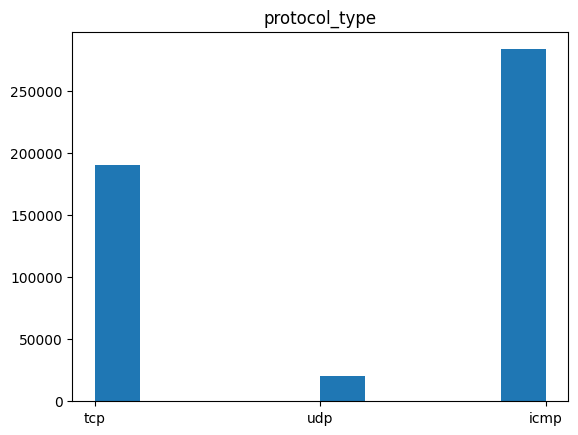

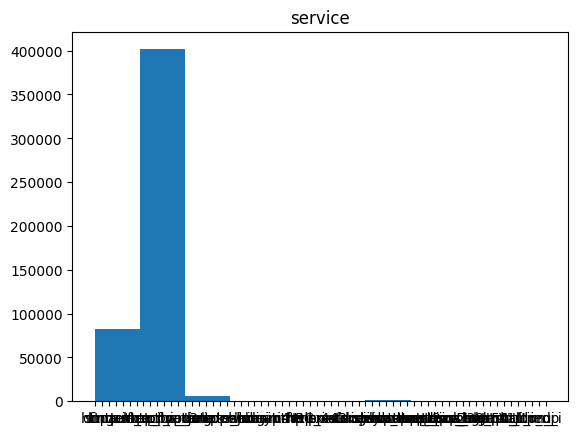

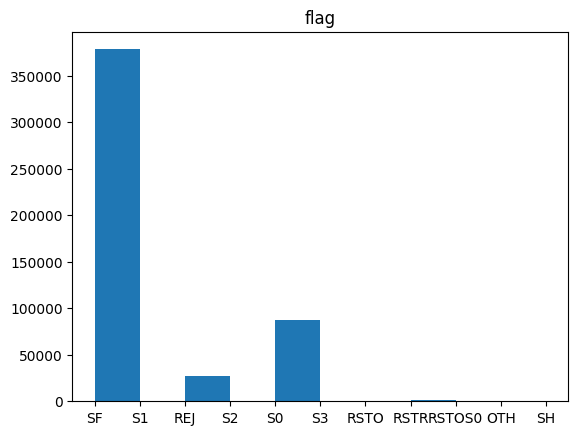

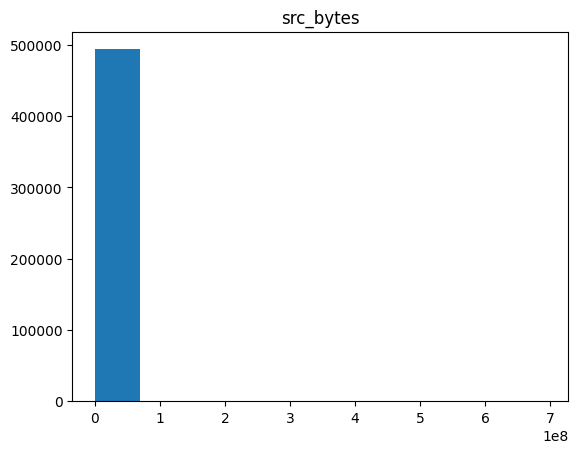

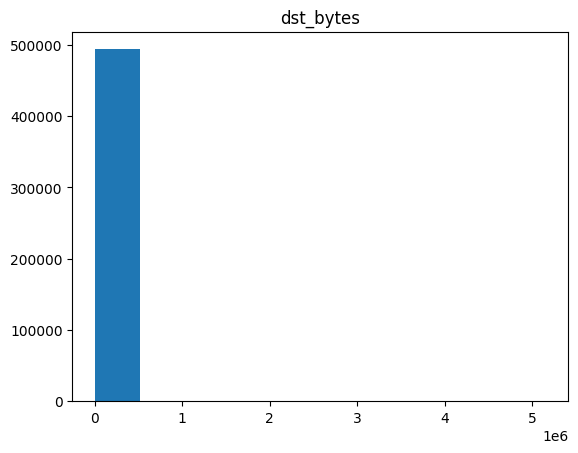

In [75]:
# Create a histogram plot for each feature
first_six_columns = df.data.iloc[:, :6]

plt.figure(5)
for col in first_six_columns:
    plt.hist(df.data[col])
    plt.title(col)
    plt.show()

# **One hot encoding**

In [52]:
df.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   duration                     494020 non-null  float64 
 1   protocol_type                494020 non-null  category
 2   service                      494020 non-null  category
 3   flag                         494020 non-null  category
 4   src_bytes                    494020 non-null  float64 
 5   dst_bytes                    494020 non-null  float64 
 6   land                         494020 non-null  category
 7   wrong_fragment               494020 non-null  float64 
 8   urgent                       494020 non-null  float64 
 9   hot                          494020 non-null  float64 
 10  num_failed_logins            494020 non-null  float64 
 11  logged_in                    494020 non-null  category
 12  lnum_compromised             494020 non-null

In [53]:
# Print columns that are of type 'category'
for idx, col in enumerate(df.data.columns):
    if pd.api.types.is_categorical_dtype(df.data[col]):
        print(f'Index: {idx}, Column: {col}')

Index: 1, Column: protocol_type
Index: 2, Column: service
Index: 3, Column: flag
Index: 6, Column: land
Index: 11, Column: logged_in
Index: 20, Column: is_host_login
Index: 21, Column: is_guest_login


In [54]:
ct_f = ColumnTransformer([("encoder", OneHotEncoder(sparse_output=False), [1,2,3,6,11,20,21])], remainder="passthrough")
new_data = ct_f.fit_transform(df.data)
df_new_data = pd.DataFrame(new_data, columns = ct_f.get_feature_names_out(), index = df.data.index)


In [70]:
# ehc = OneHotEncoder(sparse_output=False)
# tmp = [[x] for x in df['target']]
# ohe_target = ehc.fit_transform(tmp)
# ohe_target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

# **Training the Model**

**Naive Baynes**

In [71]:
# Initialize the Naive Bayes classifier
nb= GaussianNB()

# Use cross_val_predict to get the predicted probabilities
y_scores = cross_val_predict(nb, df_new_data, df['target'], method="predict_proba", cv=10)

# Calculate the ROC curve. Replace "2" with the appropriate positive label, e.g., 1 if your target labels are 0 and 1.
fpr, tpr, thresholds = roc_curve(df['target'], y_scores[:, 1], pos_label=1)


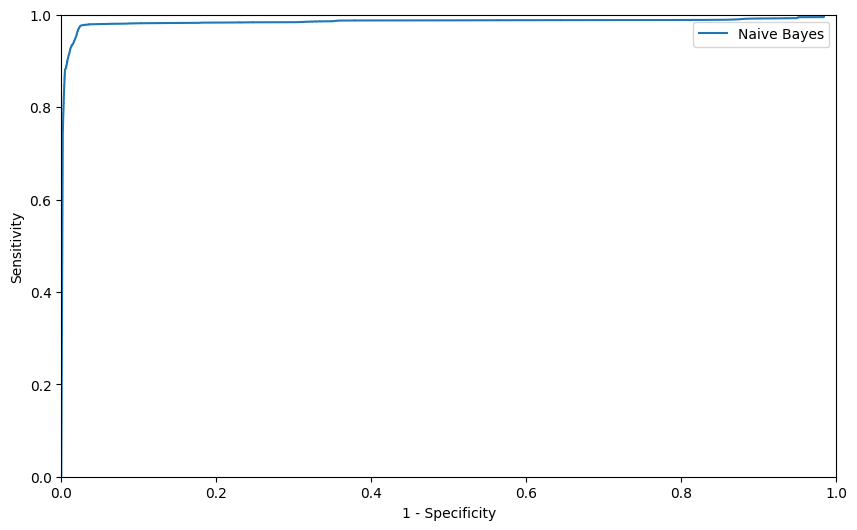

AUC score of nb: 0.9843000315290895


In [72]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="Naive Bayes")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()
print("AUC score of nb: " + str(roc_auc_score(df['target'], y_scores[:,1])))

# **Neural Network**

In [136]:
nn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=10, random_state=42)

# Use cross_val_predict to get the predicted probabilities
y_scores2 = cross_val_predict(nn, df_new_data, df['target'], method="predict_proba", cv=10)

# Calculate the ROC curve. Replace "2" with the appropriate positive label, e.g., 1 if your target labels are 0 and 1.
fpr2, tpr2, thresholds2 = roc_curve(df['target'], y_scores2[:, 1], pos_label=1)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

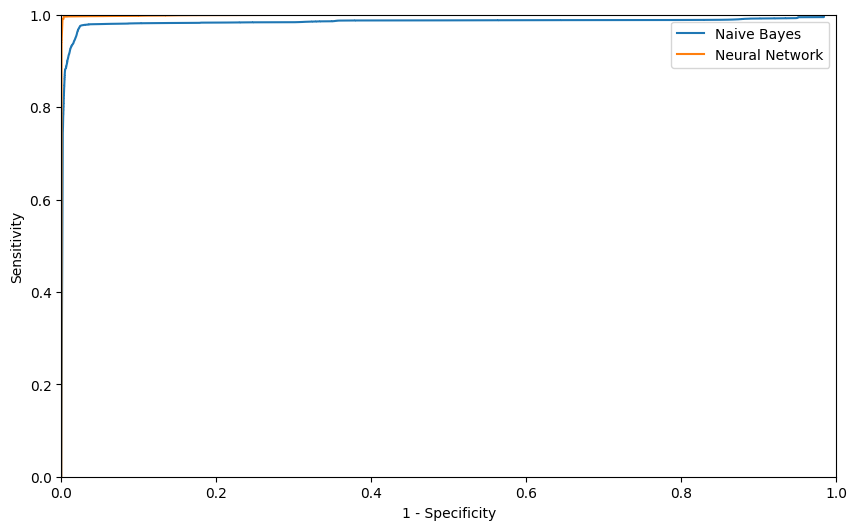

AUC score of nb: 0.9843000315290895
AUC score of nn: 0.9992339581180474


In [137]:

# plot the ROC cruve for two models
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="Naive Bayes")
plt.plot(fpr2, tpr2, label="Neural Network")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

print("AUC score of nb: " + str(roc_auc_score(df['target'], y_scores[:,1])))
print("AUC score of nn: " + str(roc_auc_score(df['target'], y_scores2[:,1])))

# **Test on a third Dataset**

In [126]:
df3 = pd.read_csv("/content/Friday-DDos.csv")

#remove space for feature name
df3.columns = df3.columns.str.strip()

Missing values in 'flow bytes/s': 28


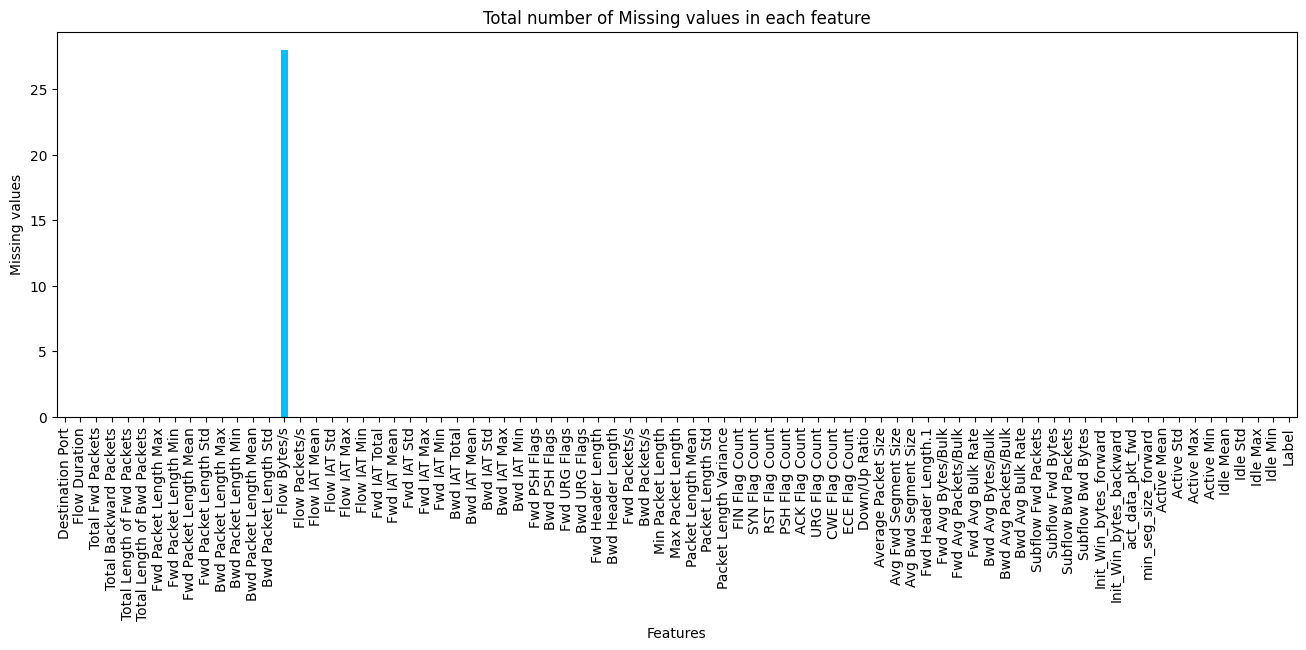

In [127]:

def plotMissingValues(dataframe):
    missing_values = dataframe.isnull().sum()  # Counting null values for each column
    missing_values_flow_bytes = dataframe['Flow Bytes/s'].isnull().sum()
    print(f"Missing values in 'flow bytes/s': {missing_values_flow_bytes}")

    fig = plt.figure(figsize=(16, 5))
    missing_values.plot(kind='bar', color='deepskyblue')
    plt.xlabel("Features")
    plt.ylabel("Missing values")
    plt.title("Total number of Missing values in each feature")
    plt.show()

plotMissingValues(df3)

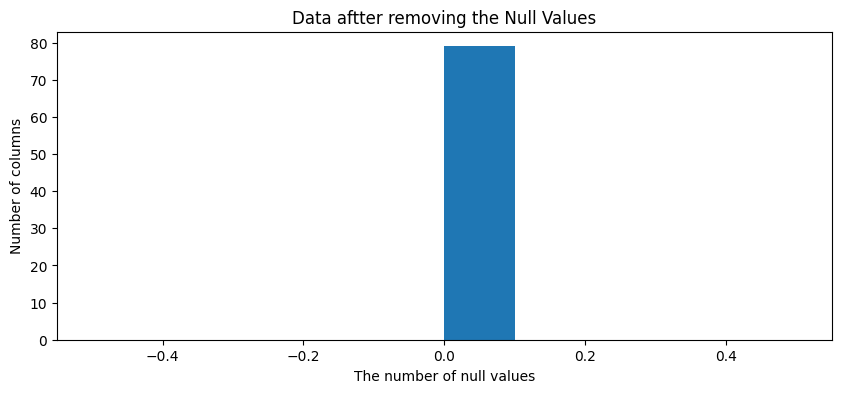

In [128]:
#drop the instances with null values
df3 = df3.dropna()

#Checking the null values in the dataset.
plt.figure(1,figsize=( 10,4))
plt.hist( df3.isna().sum())
# Set the title and axis labels
plt.title('Data aftter removing the Null Values')
plt.xlabel('The number of null values')
plt.ylabel('Number of columns')

# Show the plot
plt.show()


In [129]:
df3['Label'].unique()
# label_counts = data_f['Label'].value_counts()
# count_benign = label_counts['BENIGN']
# count_ddos = label_counts['Bot']

# plt.bar(['Benign', 'DDos'], [count_benign, count_ddos], color=['lightgreen', 'orange'],edgecolor='black')

# # Adding the title and labels
# plt.title('Number of BENIGN and DDos Instances')
# plt.xlabel('Class')
# plt.ylabel('Count')

# # Display the plot
# plt.show()

# #count
# print("Benign: ", count_benign)
# print("DDos: ", count_ddos)


array(['BENIGN', 'Bot'], dtype=object)

In [130]:
df3['Label'] = df3['Label'].map({'BENIGN': 0, 'Bot': 1})


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,0
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,0
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,0
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191028,53,61452,4,2,180,354,45,45,45.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
191029,53,171,2,2,80,272,40,40,40.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
191030,53,222,2,2,90,354,45,45,45.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
191031,123,16842,1,1,48,48,48,48,48.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0


In [140]:
# Fit the model on the entire dataset
nn.fit(df_new_data, df['target'])

X_test = df3.drop('Label',axis=1)
y_test = df3['Label']

y_pred = nn.predict(X_test)

# in order to test on a third dataset, the feature name must be same,
#it hard to find one currently, so we will stop now

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ACK Flag Count
- Active Max
- Active Mean
- Active Min
- Active Std
- ...
Feature names seen at fit time, yet now missing:
- encoder__flag_OTH
- encoder__flag_REJ
- encoder__flag_RSTO
- encoder__flag_RSTOS0
- encoder__flag_RSTR
- ...
